# Data Mining CS 619, Spring 2018 - Eleonora Renz

### Week 5 - Chapter 5

## Features and scikit-learn Transformers

In [1]:
import os 
import pandas as pd

data_folder = os.path.join(os.path.expanduser("~"),  "Desktop", "DataMining_Spring2018", "Data", "Adult")
adult_filename = os.path.join(data_folder, "adult.data")

adult = pd.read_csv(adult_filename, header=None, names=["Age", "Work-Class", "fnlwgt", "Education", "Education-Num", "Material-Status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-Country", "Earnings-Raw"])

In [2]:
# inplace just makes sure the same Dataframe is affected,
# rather than creating a new one
adult.dropna(how='all', inplace=True)

adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Material-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

#### Common feature patterns

In [3]:
# Describe an ordinal, numerical feature
adult["Hours-per-week"].describe()

count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: Hours-per-week, dtype: float64

In [4]:
# Describe an ordinal (categorical translated into numerical) feature
adult["Education-Num"].median()

10.0

In [5]:
# View unique values of the feature
adult["Work-Class"].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay', ' Never-worked'], dtype=object)

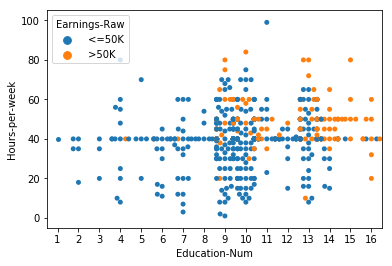

In [6]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

# show every 50eth row
sns.swarmplot(x="Education-Num", y="Hours-per-week", hue="Earnings-Raw", data=adult[::50]) 

In [7]:
# Discretizies Hours-per-week
adult["LongHours"] = adult["Hours-per-week"] > 40

#### Feature selection

<ul><li><b>Reducing complexity</b>: Many data mining algorithms need significantly more
time and resources when the number of features increase. Reducing the number
of features is a great way to make an algorithm run faster or with fewer
resources.</li>
<li><b>Reducing noise</b>: Adding extra features doesn't always lead to better
performance. Extra features may confuse the algorithm, finding correlations and
patterns in training data that do not have any actual meaning. This is common in
both smaller and larger datasets. Choosing only appropriate features is a good
way to reduce the chance of random correlations that have no real meaning.</li><li><b>
Creating readable models</b>: While many data mining algorithms will happily
compute an answer for models with thousands of features, the results may be
difficult to interpret for a human. In these cases, it may be worth using fewer
features and creating a model that a human can understand.</li></ul>

In [8]:
# Remove any feature that doesn't have at least a 
# minimum level of variance in the values
import numpy as np

x = np.arange(30).reshape((10, 3))

x[:,1] = 1

# Create a VarianceThreshold transformer and apply
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
xt = vt.fit_transform(x)

print(vt.variances_)

[ 74.25   0.    74.25]


Features with no variance do not add any value to a data mining application; however, they
can slow down the performance of the algorithm and reduce the efficacy.

#### Selecting the best individual features

In [9]:
# Extract a dataset and class values  
x = adult[["Age", "Education-Num", "Capital-gain", "Capital-loss", "Hours-per-week"]].values

In [10]:
y = (adult["Earnings-Raw"] == ' >50K').values

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

transformer = SelectKBest(score_func=chi2, k=3)
xt_chi2 = transformer.fit_transform(x, y)

print(transformer.scores_)

[  8.60061182e+03   2.40142178e+03   8.21924671e+07   1.37214589e+06
   6.47640900e+03]


In [12]:
from scipy.stats import pearsonr

def multivariate_pearsonr(x, y):
    """ Wrapper function that allows us to use 
        this for multivariate arrays"""
    scores, pvalues = [], []
    for column in range(x.shape[1]):
        # Compute the Pearson correlation for this column only
        cur_score, cur_p = pearsonr(x[:,column], y)
        # Record both the score and p-value
        scores.append(abs(cur_score))
        pvalues.append(cur_p)
    return (np.array(scores), np.array(pvalues))

In [13]:
transformer = SelectKBest(score_func = multivariate_pearsonr, k=3)
xt_pearson = transformer.fit_transform(x, y)
print(transformer.scores_)

[ 0.2340371   0.33515395  0.22332882  0.15052631  0.22968907]


In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state = 14)
scores_chi2 = cross_val_score(clf, xt_chi2, y, scoring = 'accuracy')
scores_pearson = cross_val_score(clf, xt_pearson, y, scoring="accuracy")

In [15]:
print("Chi2 score: {:.3f}".format(scores_chi2.mean()))
print("Pearson score: {:.3f}".format(scores_pearson.mean()))

Chi2 score: 0.829
Pearson score: 0.771


#### Feature creation

In [16]:
import os 
import numpy as np
import pandas as pd
data_folder = os.path.join(os.path.expanduser("~"), "Desktop", "DataMining_Spring2018", "Data")
data_filename = os.path.join(data_folder, "Ads", "ad.data")

In [17]:
d = pd.read_csv(data_filename)

C:\Users\Ellomarshmallow\MeineProgramme\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Reading this file causes trouble because there are columns with mixed datatypes, so in the next step we will convert them.

In [18]:
def convert_number(x):
    """Converts features into floats"""
    try: 
        return float(x)
    except ValueError:
        return np.nan

In [19]:
converters = {}

for i in range(1558):
    converters[i] = convert_number

In [20]:
# Set the final column to a binary feature 
converters[1558] = lambda x: 1 if x.strip() == "ad." else 0

This dataset describes images on websites, with the goal of determining whether a given
image is an advertisement or not.

In [21]:
ads = pd.read_csv(data_filename, header=None, converters=converters)
ads.head()

,0,1,2,3,4,5,6,7,8,9,...,1549,1550,1551,1552,1553,1554,1555,1556,1557,1558
0,125.0,125.0,1.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,57.0,468.0,8.2105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,33.0,230.0,6.9696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,60.0,468.0,7.8000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,60.0,468.0,7.8000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [22]:
# Drop NaN values
ads.dropna(inplace=True)
x = ads.drop(1558, axis=1).values
y = ads[1558]

#### Principal Component Analysis

The Principal Component Analysis (PCA) algorithm aims to find combinations of features that describe the dataset in less information. It aims to discover principal components, which
are features that do not correlate with each other and explain the information—specifically
the variance—of the dataset. What this means is that we can often capture most of the
information in a dataset in fewer features.<br>
The downside to transforming data with PCA is that these features are often complex
combinations of the other features. Such features are
indistinguishable by humans and it is hard to glean much relevant information from
without a lot of experience working with them.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
xd = pca.fit_transform(x)

In [24]:
# Amount of variance that is explained by each of these features:
np.set_printoptions(precision=3, suppress=True)
pca.explained_variance_ratio_

array([ 0.854,  0.145,  0.001,  0.   ,  0.   ])

In [25]:
clf = DecisionTreeClassifier(random_state=14)
scores_reduced = cross_val_score(clf, xd, y, scoring='accuracy')

<function matplotlib.pyplot.show>

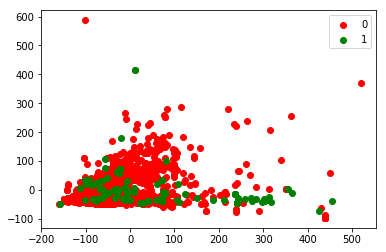

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt

classes = set(y)
colors = ['red', 'green']

for cur_class, color in zip(classes, colors):
    mask = (y == cur_class)
    plt.scatter(xd[mask, 0], xd[mask, 1], marker='o', color=color, label = int(cur_class))

plt.legend()
plt.show

#### The transformer API

Transformers have two key functions:
<ul><li><b>fit():</b> This takes a training set of data as input and sets internal parameters</li>
<li><b>transform():</b> This performs the transformation itself. This can take either the
training dataset, or a new dataset of the same format</li><br>
Both fit() and transform() functions should take the same data type as input, but

### Implementing a Transformer

In [27]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array

class MeanDiscrete(TransformerMixin):
    def fit(self, x, y=None):
        x = as_float_array(x)
        self.mean = x.mean(axis=0)
        return self
    
    def transform(self, x, y=None):
        x = as_float_array(x)
        assert x.shape[1] == self.mean.shape[0]
        return x > self.mean

In [28]:
# create an instance of this class and use it to transform our X array:
mean_discrete = MeanDiscrete()
x_mean = mean_discrete.fit_transform(x)

#### Unit testing

In [29]:
from numpy.testing import assert_array_equal

def test_meandiscrete():
    x_test = np.array([[0,2], [3,5], [6,8], [9,11], [12,14], [15,17], [18,20], [21,23], [24,26], [27,29]])
    # Create an instance of our Transformer
    mean_discrete = MeanDiscrete()
    mean_discrete.fit(x_test)
    # Check that he computed mean is correct
    assert_array_equal(mean_discrete.mean, np.array([13.5, 15.5]))
    # Also test that transform works properly
    x_transformed = mean_discrete.transform(x_test)
    x_expected = np.array([[0,0], [0,0], [0,0], [0,0], [0,0], [1,1], [1,1], [1,1], [1,1], [1,1]])
    assert_array_equal(x_transformed, x_expected)

In [30]:
# Run the test
test_meandiscrete()

As the test ran without throwing any erros, it was successful!

#### Putting it all together

In [31]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('mean_discrete', MeanDiscrete()), ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, x, y, scoring='accuracy')
print("Mean Discrete performance: {0:.3f}".format(scores_mean_discrete.mean()))

Mean Discrete performance: 0.917
